# final setup
I’ve tried many alternative, different views but I believe there is just not more information in the limited data set. Please note that we only have a sample of the E_mails, meaning that the input into the algo’s is sub-optimal.

Given that different experimental set-up don’t result in a significant different picture, I chose to use the leasts ambiguous setup and to follow the labels from Creamer (1-on-1) using detailed labels avoiding biased in the aggregation of labels.

In [1]:
# run this only once!!
import os
os. chdir("../..")
os.getcwd()

'/Users/tonpoppe/workspace/graphcase_experiments/graphcase_experiments'

In [2]:
import networkx as nx
from graphcase_experiments.algos.GraphCaseWrapper import GraphCaseWrapper
from graphcase_experiments.tools.embedding_plotter import plot_embedding2, plotly_embedding
from graphcase_experiments.tools.calculate_embed import calculate_graphcase_embedding
from graphcase_experiments.graphs.enron.mail_reader import spark
import matplotlib.pyplot as plt
import pydot
import pandas as pd
import tensorflow as tf
import pyspark.sql.functions as F

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/19 08:38:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load graph
SOURCE_PATH = 'graphcase_experiments/graphs/enron/data/'
G = nx.read_gpickle(SOURCE_PATH + 'enron_sub_graph3.pickle')

In [37]:
labels = []
for n, d in G.nodes(data=True):
    labels.append(d['label'])

pdf = pd.DataFrame(labels, columns=['labels'] )
pdf.groupby('labels')['labels'].count()

labels
attorney-legal asst.    14
ceos-president           9
director                23
employee                15
executive vp             3
manager                 15
managing director        7
specialist               8
trader                  35
vice president          22
Name: labels, dtype: int64

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-19 08:53:50.775352: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 08:55:48.920856: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


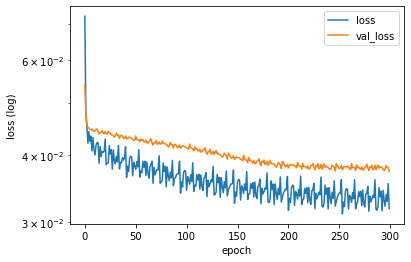

/Users/tonpoppe/workspace/graphcase_experiments/graphcase_experiments/graphcase_experiments/tools/embedding_plotter.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_df['embed1'] = embed[:,0]
/Users/tonpoppe/workspace/graphcase_experiments/graphcase_experiments/graphcase_experiments/tools/embedding_plotter.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_df['embed2'] = embed[:,1]


In [25]:
# alternative mapping - smry lbls
from graphcase_experiments.tools.calculate_embed import calculate_graphcase_embedding
from graphcase_experiments.algos.GraphCaseWrapper import GraphCaseWrapper

_, tbl = calculate_graphcase_embedding(
            G, 'graphcase_experiments/data/enron/', params=GraphCaseWrapper.ENRON_PARAMS, verbose=True, algo=GraphCaseWrapper
        )
plotly_embedding(tbl)

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



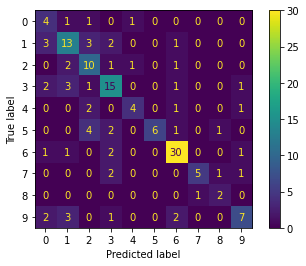

In [34]:
# get the confussion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from graphcase_experiments.experiments.ring_exp import classify_svm
svm_res = classify_svm(tbl, test_size=0.5)
ConfusionMatrixDisplay.from_predictions(tbl['label_id'], svm_res['pred_labels'])

In [40]:
tbl[['label', 'label_id']].drop_duplicates()

,label,label_id
0,managing director,0
1,vice president,1
3,employee,2
4,director,3
5,specialist,4
6,attorney-legal asst.,5
10,trader,6
22,ceos-president,7
33,executive vp,8
35,manager,9


In [44]:
G.nodes[1]

{'attr_received_size': 0.531791517680996,
 'attr_cnt_to': 0.7125429053174699,
 'attr_cnt_cc': 0.5935953401320436,
 'attr_sent_size': 0.7286380122813382,
 'attr_cnt_send': 0.7043850139439287,
 'label': 'vice president',
 'old_id': 'neal-s'}

## gridsearch

grid search took 80.9 seconds to run, 26.970109701156616 per run


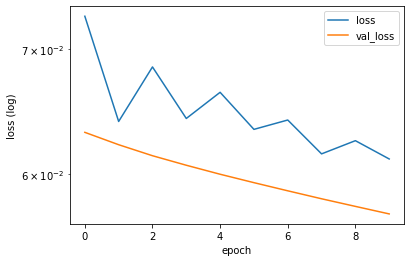

In [45]:
# gridsearch
from graphcase_experiments.tools.gridsearch import grid_search_graphcase
def search_params(trial):
    return {
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),
        'act': trial.suggest_categorical("act", ['relu', 'sigmoid', 'identity']),
        'useBN': trial.suggest_categorical("useBN", [True]),
        'dropout': trial.suggest_float("dropout", 0.1, 0.2),
        'support_size': trial.suggest_int("support_size", 7, 10),
        'dims': trial.suggest_int("dims", 32, 128)
    }
FIXED_PARAMS = {
        'batch_size': 30,
        'hub0_feature_with_neighb_dim': 128,
        'verbose': False,
        'seed': 1,
        'encoder_labels': ['attr_received_size', 'attr_cnt_to', 'attr_cnt_cc', 'attr_sent_size', 'attr_cnt_send'],
        'epochs': 10,  #1000,
        'trials': 3  #200
    }

PATH = 'graphcase_experiments/data/enron/'

grid_search_res = grid_search_graphcase(G, PATH, [search_params, FIXED_PARAMS])


In [46]:
grid_search_res[1]

{'batch_size': 30,
 'hub0_feature_with_neighb_dim': 128,
 'verbose': False,
 'seed': 1,
 'encoder_labels': ['attr_received_size',
  'attr_cnt_to',
  'attr_cnt_cc',
  'attr_sent_size',
  'attr_cnt_send'],
 'learning_rate': 2.2159539296803902e-05,
 'act': <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>,
 'useBN': True,
 'dropout': 0.16852195003967596,
 'support_size': [7, 7],
 'dims': [3, 117, 117, 117],
 'epochs': 10}

## calculate performance

In [41]:
# alternative mapping - detailed lbls
from graphcase_experiments.experiments.enron_comp import calc_enron_performance
ind, res = calc_enron_performance(G=G, test_size=0.5, runs=5)

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=3.

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/sklearn/model_selecti

KeyboardInterrupt: 